In [1]:
import os
import sys
import pathlib

# Append parent path
parent_dir = str(pathlib.Path(os.getcwd()).parent)
sys.path.append(parent_dir)

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import requests
from sqlalchemy import create_engine

### Explore metadata

In [3]:
meta = pd.read_csv("../raw/movies.dat", delimiter="::", encoding = "ISO-8859-1", header=None, 
                   names=["MovieID","Title","Genres"])

C:\Users\Hau Pham\AppData\Local\Temp\ipykernel_3876\2381048258.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  meta = pd.read_csv("../raw/movies.dat", delimiter="::", encoding = "ISO-8859-1", header=None,


In [4]:
meta.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   MovieID  3883 non-null   int64 
 1   Title    3883 non-null   object
 2   Genres   3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


As we can see, release year of the movie contain in title of movie. We can extract this to new column

In [8]:
meta['release_year'] = meta.Title.apply(lambda x: x[-5:-1])

In [9]:
# Remove release year of movie in it's title
meta.Title = meta.Title.apply(lambda x: x[:-7])

In [10]:
meta.head()

,MovieID,Title,Genres,release_year
0,1,Toy Story,Animation|Children's|Comedy,1995
1,2,Jumanji,Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama,1995
4,5,Father of the Bride Part II,Comedy,1995


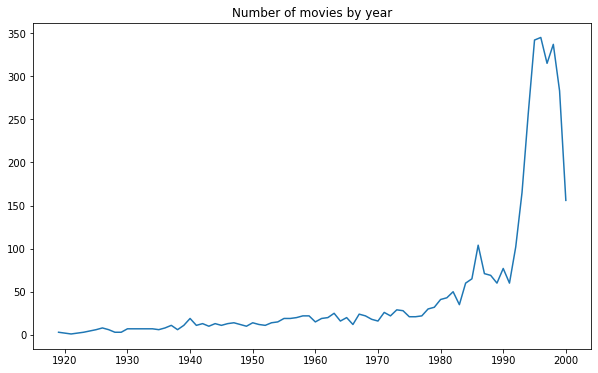

In [22]:
year_count = meta.release_year.value_counts()
plt.figure(figsize=(10,6))
sns.lineplot(x=pd.to_datetime(year_count.index), y=year_count.values)
plt.title("Number of movies by year")
plt.show()

Genres of movies contains as string type, and it's splitted by "|" comma. I will transform it into list of genre for convience explore

In [23]:
meta.Genres = meta.Genres.apply(lambda x: x.split("|"))

In [24]:
meta

,MovieID,Title,Genres,release_year
0,1,Toy Story,"[Animation, Children's, Comedy]",1995
1,2,Jumanji,"[Adventure, Children's, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama]",1995
4,5,Father of the Bride Part II,[Comedy],1995
...,...,...,...,...
3878,3948,Meet the Parents,[Comedy],2000
3879,3949,Requiem for a Dream,[Drama],2000
3880,3950,Tigerland,[Drama],2000
3881,3951,Two Family House,[Drama],2000


### Transform and explore genre of movies

In [25]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

In [26]:
genre_transform = pd.DataFrame(mlb.fit_transform(meta.Genres), columns=mlb.classes_, index=meta.index)

In [27]:
genre_transform

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3879,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3880,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3881,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [28]:
new_meta = pd.concat([meta.drop(columns=['Genres']), genre_transform], axis=1)

In [29]:
new_meta.head()

,MovieID,Title,release_year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,1995,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
genre_sum = genre_transform.sum()
genre_sum.sort_values(inplace=True)

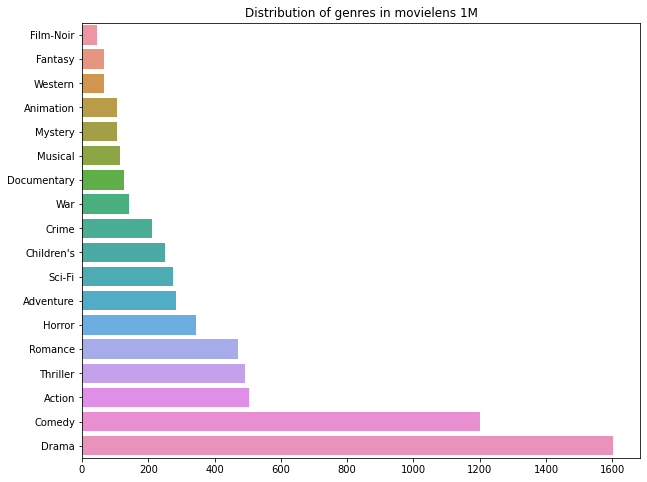

In [31]:
plt.figure(figsize=(10,8))
sns.barplot(x=genre_sum.values, y=genre_sum.index)
plt.title("Distribution of genres in movielens 1M")
plt.show()

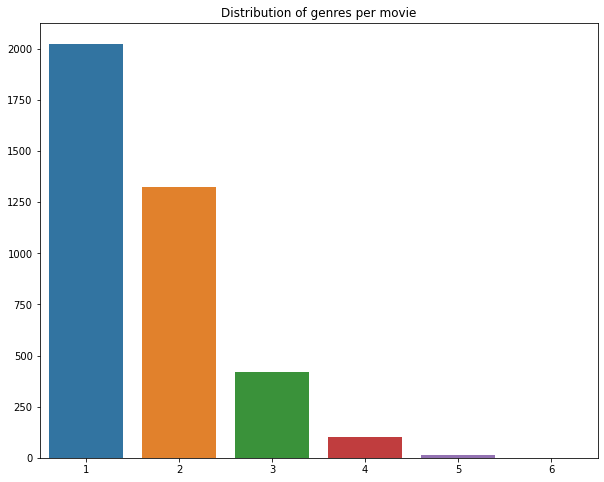

In [32]:
genres_per_item = genre_transform.sum(axis=1).value_counts()
plt.figure(figsize=(10,8))
sns.barplot(x=genres_per_item.index, y=genres_per_item.values)
plt.title("Distribution of genres per movie")
plt.show()

### Load rating data

In [33]:
rating = pd.read_csv("../raw/ratings.dat", delimiter="::", names=['UserID',"MovieID", "Rating", "Timestamp"], engine='python')

In [34]:
rating.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [35]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   UserID     1000209 non-null  int64
 1   MovieID    1000209 non-null  int64
 2   Rating     1000209 non-null  int64
 3   Timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [64]:
rating.drop(columns=['Timestamp'], inplace=True)

In [65]:
rating.nunique()

UserID     6040
MovieID    3706
Rating        5
dtype: int64

### EDA rating and it's distribution in dataset

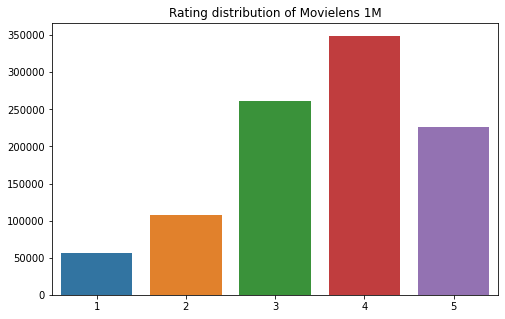

In [39]:
rating_count = rating.Rating.value_counts()
plt.figure(figsize=(8,5))
sns.barplot(x=rating_count.index, y=rating_count.values)
plt.title("Rating distribution of Movielens 1M")
plt.show()


In [47]:
mean_rate_of_movie = rating.groupby("MovieID").Rating.apply('mean')

In [49]:
mean_rate_of_movie.describe()

count    3706.000000
mean        3.238892
std         0.672925
min         1.000000
25%         2.822705
50%         3.331546
75%         3.740741
max         5.000000
Name: Rating, dtype: float64

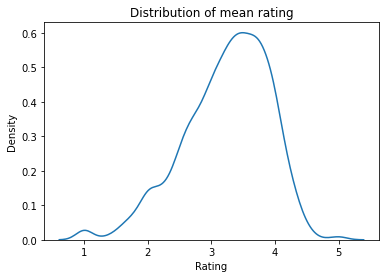

In [51]:
sns.kdeplot(mean_rate_of_movie)
plt.title("Distribution of mean rating")
plt.show()

- Almost of users give rating 3 or 4.
- The movies get lowest or highest rate is low
- Almost of rate from user is higher than median (2.5)

### EDA user review

In [42]:
rating.UserID.value_counts()

4169    2314
1680    1850
4277    1743
1941    1595
1181    1521
        ... 
5725      20
3407      20
1664      20
4419      20
3021      20
Name: UserID, Length: 6040, dtype: int64

<AxesSubplot:>

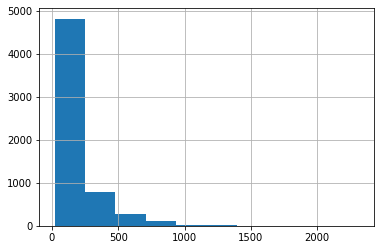

In [63]:
rating.UserID.value_counts().hist()

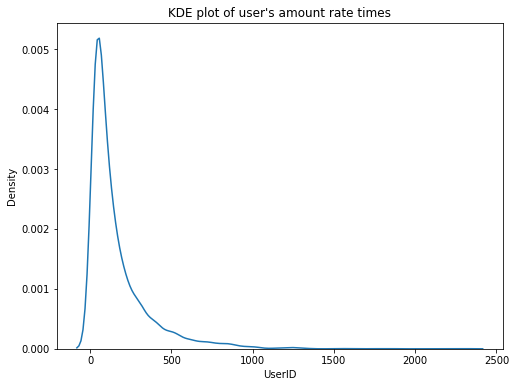

In [58]:
plt.figure(figsize=(8,6))
sns.kdeplot(rating.UserID.value_counts())
plt.title("KDE plot of user's amount rate times")
plt.show()

From the chart above

- Almost of user rate less than 100 times
- 20 is the minimum times user rate
- Some user rate more than 1000 times

### EDA Movie's rating

In [43]:
rating.MovieID.value_counts()

2858    3428
260     2991
1196    2990
1210    2883
480     2672
        ... 
3458       1
2226       1
1815       1
398        1
2909       1
Name: MovieID, Length: 3706, dtype: int64

<AxesSubplot:>

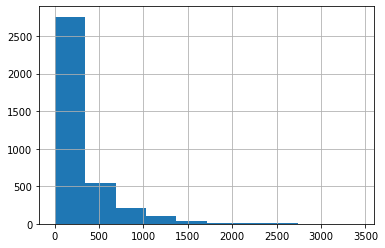

In [44]:
rating.MovieID.value_counts().hist()

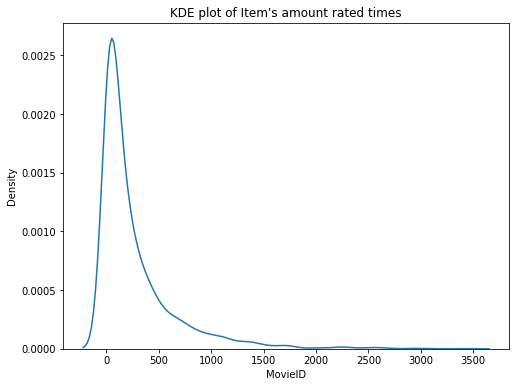

In [57]:
plt.figure(figsize=(8,6))
sns.kdeplot(rating.MovieID.value_counts())
plt.title("KDE plot of Item's amount rated times")
plt.show()

From chart about movie rating distribution
- Almost of movie has number of reviews is lower than 500
- Some movies gain a lot of reviews (more than 1000 times)
- Some movies only gain 1 reviews